# **Projet Machine Learning - Sentiment Analysis of Movie Reviews 🎬** 

## **Scraping** 

https://colab.research.google.com/drive/13zcGvhVsHCdp4nuYRHlh8XG8HdYWnJKY?usp=sharing

## **1 - Import** 

In [12]:
# Manipulation des données
import pandas as pd
import numpy as np
import shutil
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Traitement du texte (NLP)
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score


## **2 - Chargement des données**

In [13]:
df = pd.read_csv('/kaggle/input/all-film-reviews/all_film_reviews.csv', sep=';', encoding='utf-8')

df.head()


,Note,Description,Film_Name
0,4,Après avoir vu ce fameux Oppenheimer en 70mm :...,Oppenheimer
1,3,"3,25/5. J'ai du mal à comprendre certains supe...",Oppenheimer
2,2,"Beaucoup, beaucoup, beaucoup de dialogues.Beau...",Oppenheimer
3,2,"Franchement, très déçu de ce dernier film de C...",Oppenheimer
4,"3,5",Oppenheimer nous permet d'en savoir beaucoup p...,Oppenheimer


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55479 entries, 0 to 55478
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Note         55479 non-null  object
 1   Description  39530 non-null  object
 2   Film_Name    55479 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


## **3 - Exploration des données (EDA)**

### Suppression des avis vides (NaN) avant l'analyse

In [15]:
df = df.dropna(subset=["Description"])
print(f"Nombre de lignes après suppression des NaN dans 'Description' : {df.shape[0]}")


Nombre de lignes après suppression des NaN dans 'Description' : 39530


### Analyse de la distribution des notes

Notes après supressions des avis vides 

Note
0,5     2485
1       1704
1,5     1107
2       2752
2,5     2293
3       3135
3,5     3694
4       6417
4,5     5878
5      10065
Name: count, dtype: int64


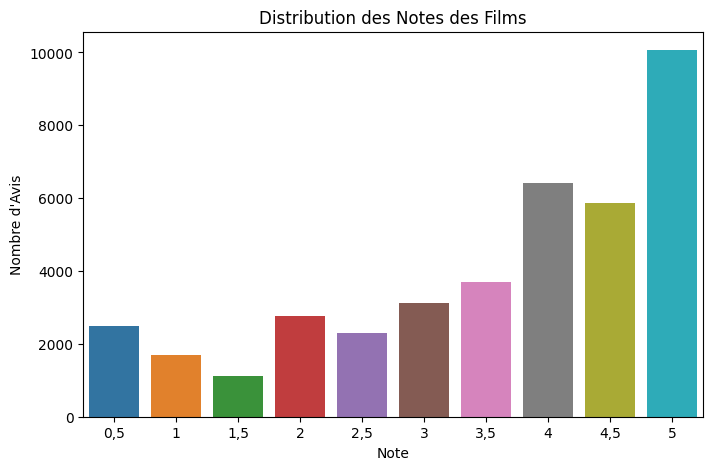

In [16]:
note_counts = df["Note"].value_counts().sort_index()
print(note_counts)

plt.figure(figsize=(8,5))
sns.barplot(x=note_counts.index, y=note_counts.values, order=note_counts.index)
plt.title("Distribution des Notes des Films")
plt.xlabel("Note")
plt.ylabel("Nombre d'Avis")
plt.show()

## **4 - Prétraitement des textes**

### Nettoyage + conversion en minuscule

In [17]:
def nettoyer_texte_brut(text):
    text = text.lower()  # minuscules
    text = re.sub(r'[^a-zA-Zéèêëàâîïôöùûüç\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text
    
df["Clean_Description"] = df["Description"].astype(str).apply(nettoyer_texte_brut)

df[["Description", "Clean_Description"]].sample(5)


,Description,Clean_Description
43847,"Franchement, on passe une bonne soirée devant ...",franchement on passe une bonne soirée devant c...
37961,Un film de guerre loin de tout ceux que nous a...,un film de guerre loin de tout ceux que nous a...
44690,Un chef-d'œuvre comme je les aime.Une pépite d...,un chef d uvre comme je les aime une pépite du...
35430,Je n'avais pas pris de claque si intense au ci...,je n avais pas pris de claque si intense au ci...
34471,Réalisateur émérite et déjà auteur de plusieur...,réalisateur émérite et déjà auteur de plusieur...


### Suppression des stopwords

In [18]:
nltk.download("stopwords")

stop_words = set(stopwords.words("french"))

def supprimer_stopwords(text):
    words = text.split()  
    words = [word for word in words if word.lower() not in stop_words]  
    return " ".join(words)  

df["Clean_Description"] = df["Clean_Description"].astype(str).apply(supprimer_stopwords)

df[["Description", "Clean_Description"]].sample(5)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Description,Clean_Description
16466,Tout commence très bien. Le postulat de départ...,tout commence très bien postulat départ scénar...
25579,"pour aimer ce film, il ne faut pas aimer le ci...",aimer film faut aimer cinéma ok acteurs reste ...
39012,Très bon film sur un épisode particulier de la...,très bon film épisode particulier guerre halet...
49521,"Académique, un peu long mais néanmoins on se l...",académique peu long néanmoins laisse cueillir ...
13622,"Tom Cruise égal à lui-même, très bon acteur. C...",tom cruise égal très bon acteur film impressio...


### Tokenisation des avis

In [19]:
def tokeniser_text(text):
    return word_tokenize(text)  

df["Tokenized_Description"] = df["Clean_Description"].astype(str).apply(tokeniser_text)

df[["Description", "Clean_Description", "Tokenized_Description"]].sample(5)

,Description,Clean_Description,Tokenized_Description
23036,Un grand film. tout ce qui se passe ici parle ...,grand film tout passe ici parle vie pourtant e...,"[grand, film, tout, passe, ici, parle, vie, po..."
22352,"Super film avec de belle scène !Très long,hâte...",super film belle scène très long hâte avoir su...,"[super, film, belle, scène, très, long, hâte, ..."
39772,Sans doute la meilleure histoire possible où l...,sans doute meilleure histoire possible où idée...,"[sans, doute, meilleure, histoire, possible, o..."
28128,C'est un bon film américain sur les débuts de ...,bon film américain débuts venus serena william...,"[bon, film, américain, débuts, venus, serena, ..."
3361,"Excellent film, artistiquement très beau, orig...",excellent film artistiquement très beau origin...,"[excellent, film, artistiquement, très, beau, ..."


### Lemmatisation des mots 

In [20]:
#Take 1min

try:
    nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])  
except OSError:
    import spacy.cli
    spacy.cli.download("fr_core_news_sm")
    nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])


def lemmatizetexts(texts):
    texts = [str(text) for text in texts]  # Conversion en string
    return [" ".join([token.lemma_ for token in doc]) for doc in nlp.pipe(texts, batch_size=50, n_process=2)]


df['Clean_Description'] = lemmatizetexts(df['Clean_Description'].astype(str).tolist())

print(df[['Description', 'Clean_Description']].head())

                                         Description  \
0  Après avoir vu ce fameux Oppenheimer en 70mm :...   
1  3,25/5. J'ai du mal à comprendre certains supe...   
2  Beaucoup, beaucoup, beaucoup de dialogues.Beau...   
3  Franchement, très déçu de ce dernier film de C...   
4  Oppenheimer nous permet d'en savoir beaucoup p...   

                                   Clean_Description  
0  après avoir voir fameux oppenheimer mm très bo...  
1  mal comprendre certain superlatif propo film t...  
2  beaucoup beaucoup beaucoup dialogue beaucoup b...  
3  franchement très déçu dernier film christopher...  
4  oppenheimer permettre savoir beaucoup plus inv...  


## **5 - Annotation et définition des labels**

- Positif : Note ≥ 4
- Négatif : Note < 4

In [21]:
print("Valeurs uniques dans 'Note' avant conversion :", df["Note"].unique())


Valeurs uniques dans 'Note' avant conversion : ['4' '3' '2' '3,5' '2,5' '5' '0,5' '1' '1,5' '4,5']


Sentiment
Positif    22360
Négatif    17170
Name: count, dtype: int64


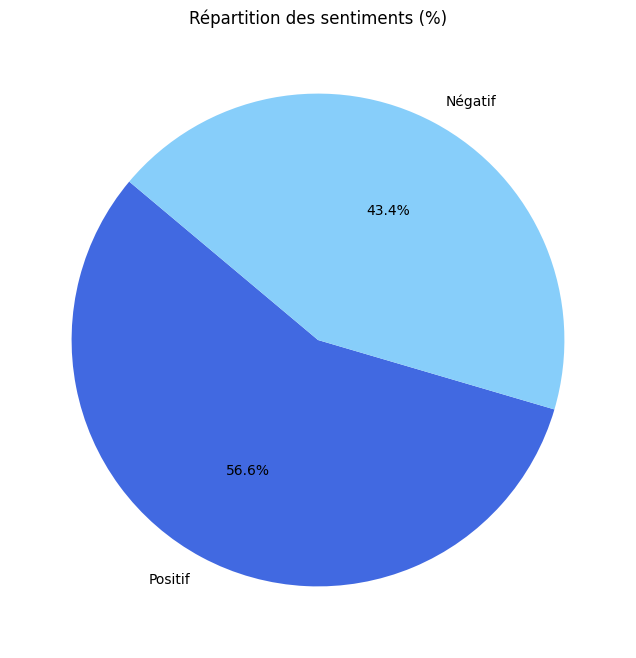

In [22]:
df["Note"] = df["Note"].astype(str).str.replace(",", ".").astype(float) # -> conversion en float

def assigner_sentiment(note):
    if pd.isna(note):
        return "Inconnu"
    elif note >= 4:
        return "Positif"
    else:
        return "Négatif"

df["Sentiment"] = df["Note"].apply(assigner_sentiment)

print(df["Sentiment"].value_counts())

df["Sentiment"] = df["Note"].apply(assigner_sentiment)

#-------------------------------------------------------------#



sentiment_counts = df["Sentiment"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#4169E1', '#87CEFA'])
plt.title("Répartition des sentiments (%)")
plt.show()

## **6 - Vectorisation des textes**

### **TfidfVectorizer (TF-IDF)**

### Ce code transforme les descriptions de films en une matrice numérique (TF-IDF) où chaque description est représentée par un vecteur basé sur l'importance des mots, après un nettoyage du texte et l'exclusion des mots fréquents peu pertinents, pour faciliter l'analyse ou l'entraînement de modèles.

In [23]:

vectorizer_tfidf = TfidfVectorizer(
    token_pattern=r'\b[a-zA-ZÀ-ÖØ-öø-ÿ]{3,}\b',  # Exclut les nombres et les mots < 3 lettres
    ngram_range=(1, 2),  # Unigrammes et bigrammes
    max_features=50000,  # Garde les 50 000 mots les plus fréquents
    max_df=0.85,  # Ignore les mots présents dans plus de 85% des documents
    min_df=10  # Ignore les mots présents dans moins de 10 documents
)

X_tfidf = vectorizer_tfidf.fit_transform(df["Clean_Description"])

print(f"Shape de la matrice TF-IDF : {X_tfidf.shape}")

print("Quelques mots du vocabulaire :", vectorizer_tfidf.get_feature_names_out()[:10])

Shape de la matrice TF-IDF : (39530, 34772)
Quelques mots du vocabulaire : ['aaron' 'aaron sorkin' 'abandon' 'abandonn' 'abandonner' 'abandonné'
 'abasourdi' 'abattr' 'abattre' 'abattu']


### Moyenne des valeurs TF-IDF par mot

In [24]:
tfidf_means = np.mean(X_tfidf.toarray(), axis=0)

top_words = np.argsort(tfidf_means)[-50:][::-1]
print("50 mots ou expressions les plus significatifs selon TF-IDF :", vectorizer_tfidf.get_feature_names_out()[top_words])
print("Scores TF-IDF moyens correspondants :", tfidf_means[top_words])

top_words_df = pd.DataFrame({"Mot": vectorizer_tfidf.get_feature_names_out()[top_words], "Score_TFIDF": tfidf_means[top_words]})
print(top_words_df.head(10))

50 mots ou expressions les plus significatifs selon TF-IDF : ['film' 'avoir' 'tout' 'très' 'bien' 'voir' 'plus' 'faire' 'acteur' 'bon'
 'pouvoir' 'histoire' 'scène' 'peu' 'sans' 'grand' 'comme' 'long'
 'scénario' 'personnage' 'trop' 'être' 'cela' 'heure' 'vraiment' 'aller'
 'passer' 'aussi' 'premier' 'cinéma' 'fin' 'beaucoup' 'rien' 'dire'
 'excellent' 'moment' 'chef' 'très bon' 'mettre' 'image' 'autre' 'bel'
 'magnifique' 'uvre' 'incroyable' 'temps' 'prendre' 'fois' 'joker'
 'quelque']
Scores TF-IDF moyens correspondants : [0.04496697 0.02782379 0.02492163 0.02392025 0.02015097 0.02006871
 0.01957469 0.01842124 0.01703391 0.01674533 0.01527122 0.01505669
 0.0134087  0.01309716 0.0130009  0.01227165 0.01203747 0.0119661
 0.0118701  0.01175905 0.01175353 0.01126551 0.01101395 0.01058829
 0.01051164 0.01043602 0.01024632 0.00978457 0.00973765 0.00972061
 0.00945965 0.0090879  0.00889171 0.00859103 0.00859063 0.0081605
 0.00804341 0.00789412 0.0076973  0.00766798 0.00758663 0.00750964
 0.

## **7 - Construction et entraînement des modèles**

### Séparation des données en train et test (train_test_split)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

print(f"Taille du train set : {X_train.shape}")
print(f"Taille du test set : {X_test.shape}")


Taille du train set : (31624, 34772)
Taille du test set : (7906, 34772)


#### **Ce code divise les données vectorisées (X_tfidf) et leurs étiquettes ("Sentiment") en deux ensembles :**

#### - 80% pour l'entraînement (X_train, y_train) afin d'entraîner le modèle.
#### - 20% pour le test (X_test, y_test) afin d'évaluer ses performances sur des données inédites.
#### L'option stratify=df["Sentiment"] garantit que la répartition des classes (positif/négatif) est préservée dans les deux ensembles, ce qui permet d'obtenir une évaluation plus fiable.

### LogisticRegression (régression logistique)

Régression Logistique - Accuracy : 0.8664305590690615
Classification Report:
               precision    recall  f1-score   support

     Négatif       0.87      0.82      0.84      3434
     Positif       0.86      0.91      0.88      4472

    accuracy                           0.87      7906
   macro avg       0.87      0.86      0.86      7906
weighted avg       0.87      0.87      0.87      7906



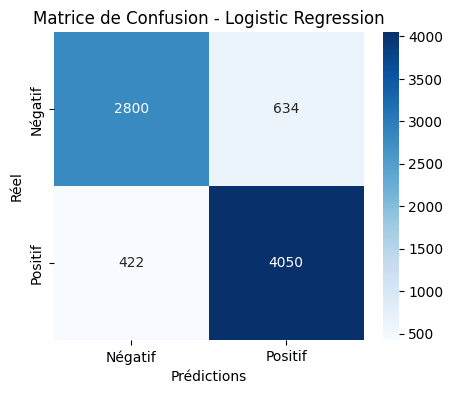

In [26]:
# random_state pour la reproductibilité et max_iter pour la convergence
model_lr = LogisticRegression(random_state=42, max_iter=1000)

model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_test)

#Accuracy
accuracy_lr = accuracy_score(y_test, predictions_lr)
print("Régression Logistique - Accuracy :", accuracy_lr)

#Rapport de classification
print("Classification Report:\n", classification_report(y_test, predictions_lr))

#Matrice
cm = confusion_matrix(y_test, predictions_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Logistic Regression")
plt.show()


#### Le modèle de **Régression Logistique** affiche une **accuracy de 86,6%**, avec une bonne précision et un F1-score équilibré. Il détecte bien les avis positifs (91% de rappel) mais a plus de mal avec les négatifs (81%), entraînant des erreurs d’interprétation. La matrice de confusion met en évidence ces faux positifs et négatifs, suggérant qu'un ajustement des seuils ou un modèle plus avancé pourrait améliorer la classification.

### RandomForestClassifier (forêt aléatoire)

Forêt Aléatoire - Accuracy : 0.8286111813812295
Classification Report:
               precision    recall  f1-score   support

     Négatif       0.81      0.80      0.80      3434
     Positif       0.84      0.85      0.85      4472

    accuracy                           0.83      7906
   macro avg       0.83      0.82      0.83      7906
weighted avg       0.83      0.83      0.83      7906



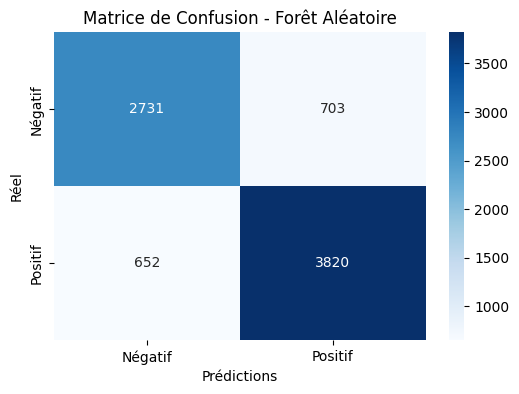

In [27]:
from sklearn.model_selection import cross_val_score

model_rf = RandomForestClassifier(
    n_estimators=200,      # Plus d'arbres pour plus de stabilité
    max_depth=30,          # éviter le sur-apprentissage
    random_state=42,       # reproductibilité
    class_weight="balanced"  
)
#CV Score
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring="accuracy")

model_rf.fit(X_train, y_train)

predictions_rf = model_rf.predict(X_test)

# Accuracy
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Forêt Aléatoire - Accuracy :", accuracy_rf)

# Rapport de classification
print("Classification Report:\n", classification_report(y_test, predictions_rf))

# Matrice de confusion
cm_rf = confusion_matrix(y_test, predictions_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Négatif", "Positif"],
            yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Forêt Aléatoire")
plt.show()

#### Le modèle Forêt Aléatoire avec 300 arbres atteint une **accuracy de 82,76%**, améliorant légèrement la détection des avis positifs (recall 85%). La matrice de confusion montre une réduction des faux négatifs, rendant le modèle plus fiable. L’augmentation du nombre d’arbres a permis un meilleur équilibre entre précision et rappel, bien que le temps d'entraînement soit légèrement plus long

### Naive Bayes (MultinomialNB).

Naïve Bayes - Accuracy : 0.8574500379458639
Classification Report:
               precision    recall  f1-score   support

     Négatif       0.87      0.78      0.83      3434
     Positif       0.85      0.91      0.88      4472

    accuracy                           0.86      7906
   macro avg       0.86      0.85      0.85      7906
weighted avg       0.86      0.86      0.86      7906



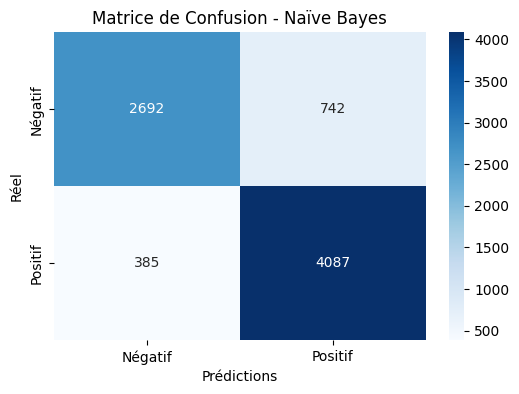

In [28]:
model_nb = MultinomialNB()

model_nb.fit(X_train, y_train)

predictions_nb = model_nb.predict(X_test)

#Acccuracy
accuracy_nb = accuracy_score(y_test, predictions_nb)
print("Naïve Bayes - Accuracy :", accuracy_nb)

# Rapport de classification
print("Classification Report:\n", classification_report(y_test, predictions_nb))

# Matrice de confusion
cm_nb = confusion_matrix(y_test, predictions_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Négatif", "Positif"],
            yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Naïve Bayes")
plt.show()


#### Le modèle **Naïve Bayes** atteint une **accuracy de 85,5%**, avec une bonne détection des avis positifs (recall de 93%) mais une tendance à sous-classer les avis négatifs (recall de 76%). Il privilégie donc les prédictions positives, ce qui peut être utile selon l’objectif de l’analyse.

### SVM

SVM - Accuracy : 0.860865165696939
Classification Report:
               precision    recall  f1-score   support

     Négatif       0.85      0.83      0.84      3434
     Positif       0.87      0.89      0.88      4472

    accuracy                           0.86      7906
   macro avg       0.86      0.86      0.86      7906
weighted avg       0.86      0.86      0.86      7906



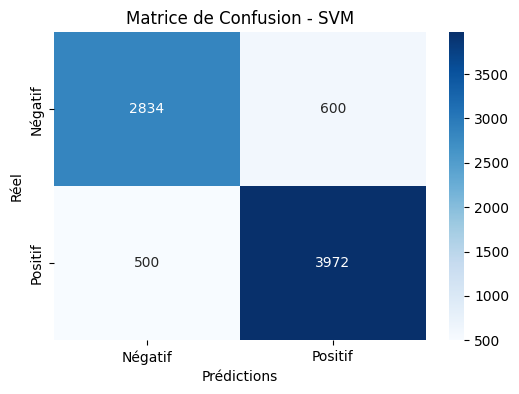

In [29]:

model_svm = LinearSVC(random_state=42)

model_svm.fit(X_train, y_train)

predictions_svm = model_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, predictions_svm)
print("SVM - Accuracy :", accuracy_svm)


print("Classification Report:\n", classification_report(y_test, predictions_svm))

cm_svm = confusion_matrix(y_test, predictions_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Négatif", "Positif"],
            yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - SVM")
plt.show()


## 8 - Evaluation des performances

### Comparaison des performances des modèles : Accuracy et Precision_score

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


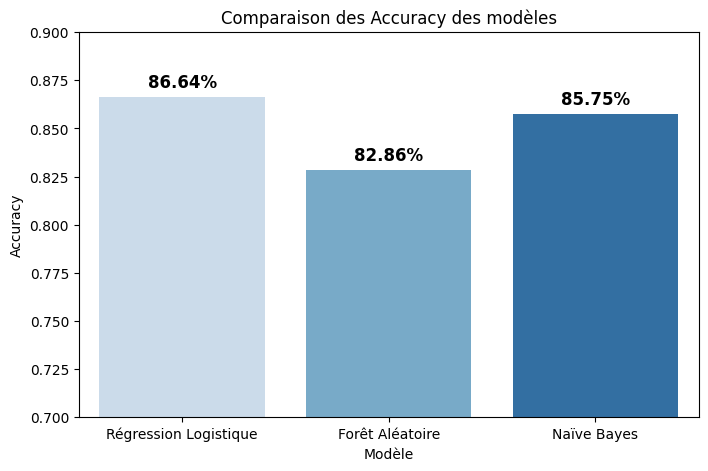

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


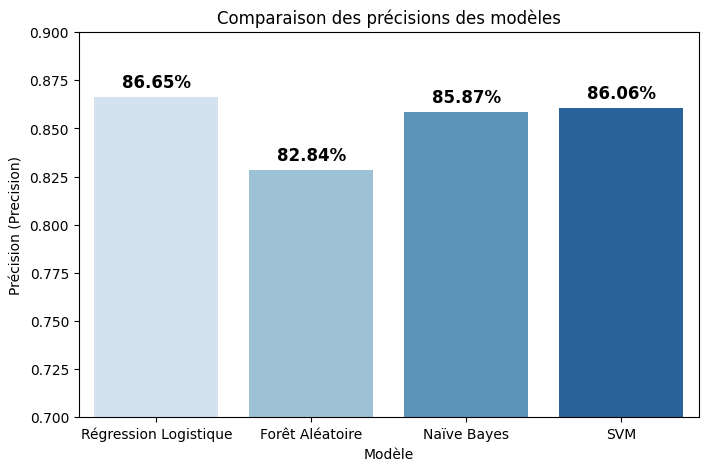

In [30]:
accuracy_scores = {
    "Régression Logistique": accuracy_lr,
    "Forêt Aléatoire": accuracy_rf,
    "Naïve Bayes": accuracy_nb
}


plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="Blues")


for i, v in enumerate(accuracy_scores.values()):
    ax.text(i, v + 0.005, f"{v:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.ylim(0.7, 0.9)  # Ajuste selon tes valeurs
plt.xlabel("Modèle")
plt.ylabel("Accuracy")
plt.title("Comparaison des Accuracy des modèles")
plt.show()


precision_scores = {
    "Régression Logistique": precision_score(y_test, predictions_lr, average="weighted"),
    "Forêt Aléatoire": precision_score(y_test, predictions_rf, average="weighted"),
    "Naïve Bayes": precision_score(y_test, predictions_nb, average="weighted"),
    "SVM": precision_score(y_test, predictions_svm, average="weighted"),
}


plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(precision_scores.keys()), y=list(precision_scores.values()), palette="Blues")

for i, v in enumerate(precision_scores.values()):
    ax.text(i, v + 0.005, f"{v:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.ylim(0.7, 0.9)  # Ajuste selon tes valeurs
plt.xlabel("Modèle")
plt.ylabel("Précision (Precision)")
plt.title("Comparaison des précisions des modèles")
plt.show()


## 9 - Visualisation des résultats

### Distribution des sentiments

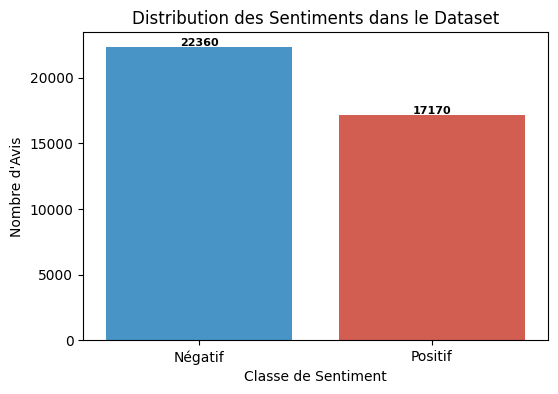

In [31]:

sentiment_counts = df["Sentiment"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["#3498db", "#e74c3c"])

for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, str(v), ha="center", fontsize=8, fontweight="bold")

plt.xlabel("Classe de Sentiment")
plt.ylabel("Nombre d'Avis")
plt.title("Distribution des Sentiments dans le Dataset")
plt.xticks(ticks=[0, 1], labels=["Négatif", "Positif"])
plt.show()

#### Le fait que 4 étoiles soient considérés comme positifs joue un rôle, mais c'est surtout la présence des 3 étoiles dans la catégorie négative qui déséquilibre les données. Une classe neutre pourrait être une bonne alternative pour une analyse plus fine

### Interprétabilité basé la régression logistique

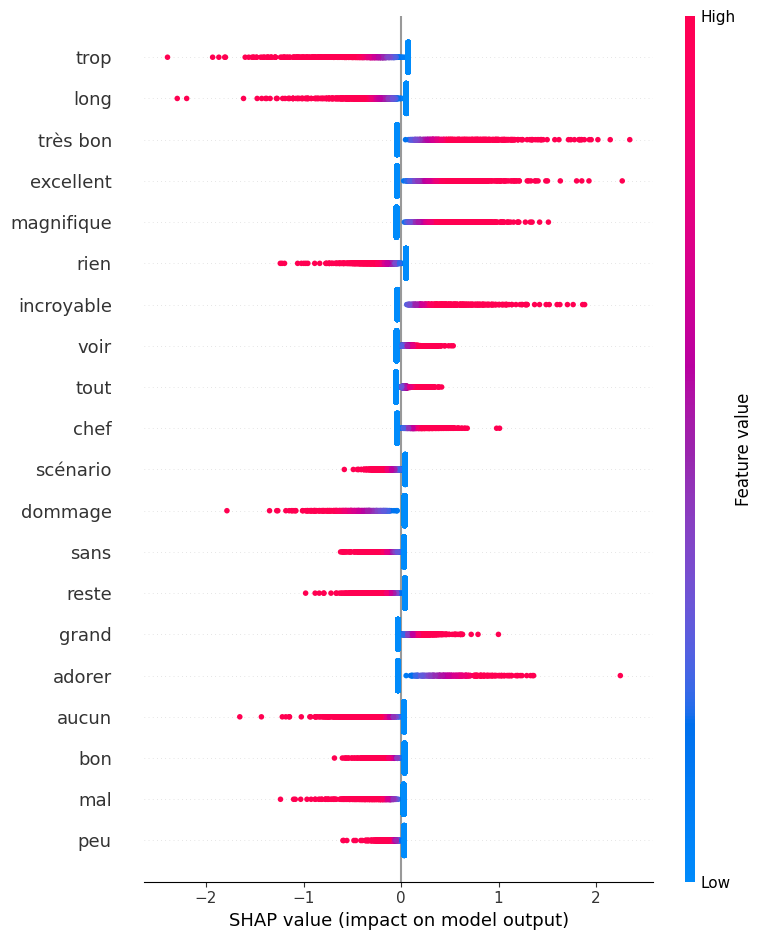

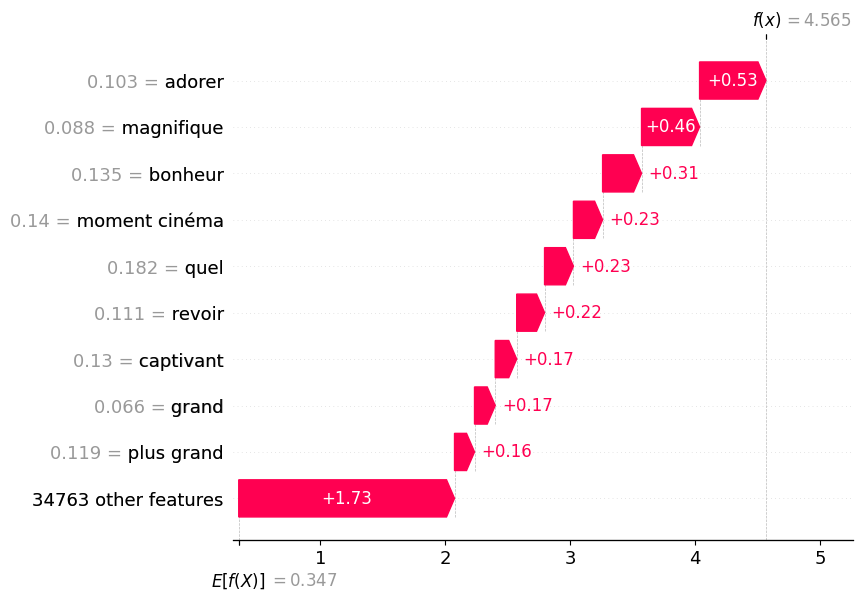

In [42]:
X_train_dense = X_train.toarray()  # Conversion en format dense
X_test_dense = X_test.toarray()


try:
    feature_names = vectorizer_tfidf.get_feature_names_out()
except NameError:
    feature_names = None  # Si vectorizer n'est pas défini, utiliser None


explainer = shap.Explainer(model_lr, X_train_dense)

shap_values = explainer(X_test_dense)

shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names)

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],  # Pour la classe 1 (ajuster si besoin)
        feature_names=vectorizer_tfidf.get_feature_names_out()
    )
)